## Overview

For some networks, certain lines can cause the $A$ matrix to be rank-deficient. Ian notes that this problem either has a physical interpretation, or is a manifestation of a bad model.

I believe all rank deficiencies may be interpreted using injection shift factors. The ISF matrix may be used to filter lines before performing temporal instanton analysis.

The upshot is that I can be confident that there is good separation between "zero" and nonzero singular values. I should therefore be able to replace QR decomposition with the faster LU. Thus, in addition to reducing the number of lines that must be analyzed, an ISF pre-check should make it possible to speed up the analysis of remaining lines.

## The problem

I first noticed the problem when running through various Matpower networks. The first step in temporal instanton analysis is to translate the problem by a vector $x^*$, where $A_1x_1^* + A_2x_2^* = 0$. To find $x^*$, I needed to compute the pseudo-inverse of $Z = [A_1~~A_2]^\top$. The line in question is

```julia
x_star[[idx1;idx2]] = (Z/(Z'*Z))*b
```
When analyzing the `case9` network, I noticed that $Z^\top Z$ did not have an inverse for some lines. The error came back:

```
ERROR: ArgumentError: matrix has one or more zero pivots
 in ldltfact at sparse/cholmod.jl:1201
 in ldltfact at sparse/cholmod.jl:1208
 in factorize at sparse/linalg.jl:651
 in \ at linalg/generic.jl:314
 in / at linalg/generic.jl:322
 ```
 
 For $Z^\top Z$ to be invertible (i.e. have no zero pivots), it must have full rank $(n+2)T$. **What are the conditions that cause $Z^\top Z$ to be rank-deficient?**

## Physical intuition
The `case9` network has a central ring (4 -> 5 -> 6 -> 7 -> 8 -> 9 -> 4) and three dangling nodes (1,2,3). Each dangling node has a generator, but in the Matpower data one of the generators (at node 1) is dispatched to zero. I converted the generator at node 3 into a wind farm, so **the only conventional generation node was node 2**. This effectively renders node 2 the slack bus. The only generation sources are at node 2 and any nodes where I place wind generation. If I introduce just one wind farm and place it at node 2, it doesn't matter what line we consider; there is no way for renewable generation changes to influence line flows.

This motivates a more thorough study.

<img src="../images/case9graph.svg">
*Simple sketch of `case9` network (ignore edge directions)*

## Systematic approach
Suppose a network has $N$ nodes and $L$ lines. Let $D_{nz}$ be a $L\times N$ matrix. Now consider each pairing of a line $l$ with a node $n$. Place a single wind farm at $n$ and form the $Z$ matrix. If $Z^\top Z$ is singular, let $D_{nz}[l,n] = 0$. Otherwise, let $D_{nz}[l,n] = 1$.

Now let's see if we can replicate $D_{nz}$ using injection shift factors. The ISF matrix has the same dimensions as $D_{nz}$. It contains positive and negative elements, and some elements may be fairly small. Take the absolute value of the ISF matrix. Now replace every element greater than some epsilon by 1, and replace every other element with zero. Call this modified ISF matrix $I_{nz}$. Like $D_{nz}$, it is a $L\times N$ matrix of zeros and ones.

I computed $D_{nz}$ and $I_{nz}$ for `case9` and `case118`. They were identical in both cases. For `case9` it is easy to add and move generators and change their participation factors, so I made a variety of changes. No matter how I moved generators around, $I_{nz}$ exactly matched $D_{nz}$. This suggests that I can use the ISF matrix to predict whether $Z$ will be rank-deficient.

## Injection shift factors
An injection shift factor for node $i$ and line $j$ is defined as the change in flow on $j$ induced by an injection of 1 pu at node $i$. In the absence of droop response, we have:

\begin{align*}
P_{ij} &= B_{ij}(\theta_i-\theta_j) \\
\theta &= B^{-1} P
\end{align*}

\begin{align*}
ISF &= B_{flow}B^{-1} \\
B_{flow}[l,:] &= \begin{bmatrix}
0 & 0 & B_{ij} & 0 & -B_{ij} \end{bmatrix}
\end{align*}

$B_{flow}$ has one row for each line $l$ in the network. It has $B_{ij}$ in the $i$th column and $-B_{ij}$ in the $j$th column.

When we do have droop response, the column of $B$ corresponding to the angle reference node is replaced by the vector of participation factors. The column of $B_{flow}$ corresponding to the reference node is replaced by a column of zeros. I wrote a function called `isf()` to return the ISF matrix for a choice of network, reference node, and participation vector.

## Numerical study
The following cell uses functions I wrote (which may be found at the end of the notebook) to compute and compare $D_{nz}$ and $I_{nz}$ for any Matpower network.

In [2]:
cname = "case9"
Dnz = find_rank_deficiencies(cname)
println("No. of rank-deficient cases: $(length(find(Dnz.==0)))")

No. of rank-deficient cases: 29


In [3]:
i = mat2tmpinst(cname)
ISF = isf(i.Y,i.lines,i.ref,i.k)
small = 1e-8
Inz = convert(Array{Int,2},abs(ISF) .> small)

# Boolean comparison
println("Dnz == Inz: $(Dnz == Inz)")

Dnz == Inz: true


In [17]:
ISFt = ISF[:,i.Ridx]

sing_line_idx = find(1 - [maxabs(ISFt[i,:])>1e-8 for i in 1:size(ISFt,1)])

4-element Array{Int64,1}:
 113
 177
 183
 184

In [12]:
i.lines

186-element Array{Tuple{Int64,Int64},1}:
 (1,2)    
 (1,3)    
 (4,5)    
 (3,5)    
 (5,6)    
 (6,7)    
 (8,9)    
 (8,5)    
 (9,10)   
 (4,11)   
 (5,11)   
 (11,12)  
 (2,12)   
 ⋮        
 (109,110)
 (110,111)
 (110,112)
 (17,113) 
 (32,113) 
 (32,114) 
 (27,115) 
 (114,115)
 (68,116) 
 (12,117) 
 (75,118) 
 (76,118) 

## Conclusion
Every rank deficiency for `case9` is explained by injection shift factors. This motivates a pre-check: before performing temporal instanton analysis, I will build the ISF matrix and look at columns corresponding to renewable nodes. A row of zeros in this matrix indicates that the corresponding line is completely insensitive to changes in renewable generation. Such a line should be neglected in temporal instanton analysis; there is no change in wind that could cause it to reach its temperature limit. Having filtered out these lines, I can perform temporal instanton analysis on the remaining ones.

## Appendix: code
The following cell contains two functions. The first builds $D_{nz}$. The second returns the ISF matrix (from which $I_{nz}$ is derived).

In [1]:
include("../src/TemporalInstanton.jl")
using TemporalInstanton
import TemporalInstanton.partition_A
import TemporalInstanton.createY

"""
For a matrix with N nodes and L lines, return a L-by-N
matrix Dnz. Dnz[l,n] = 0 when Z(l,n) is rank-deficient
(i.e. there are zero pivots while factorizing Z'*Z).
All other elements of Dnz are equal to 1.
"""
function find_rank_deficiencies(cname)
    i = mat2tmpinst(cname)

    conductor_params = return_conductor_params("waxwing")
    # Thermal model parameters:
    i.Tamb = 35. # C
    i.T0 = 60. #46. # initial line steady-state temp

    i.time_values = 0:30:300 # five minutes in 30-sec steps
    i.int_length = 300. # seconds = 5 min

    Gp,Dp,Rp = (i.G0, i.D0, i.R0)

    # one time step to keep things simple
    i.G0 = collect(Gp)
    i.D0 = collect(Dp)
    i.R0 = collect(Rp)

    n = length(i.k)
    nr = length(i.Ridx)
    T = convert(Int64,length(i.G0)/n)
    Qobj = tmp_inst_Qobj(n,nr,T,i.corr)

    # figure out where rank deficiencies are occurring
    defic = zeros(length(i.lines),size(i.Y,1))
    for idx in 1:length(i.lines)
        for nodeLoc in 1:size(i.Y,1)
            # modify the wind node location
            i.Ridx = collect(nodeLoc)

            line = i.lines[idx]
            line_params = LineParams(line[1],line[2],i.res[idx],i.reac[idx],i.line_lengths[idx])
            therm_a, therm_c, therm_d, therm_f = return_thermal_constants(line_params,
            conductor_params, i.Tamb, i.Sb, i.int_length, T, i.T0)

            A1 = tmp_inst_A1(i.Ridx,T,i.Y,i.ref,i.k)
            A2 = tmp_inst_A2(n,i.Ridx,T,line,therm_a,i.int_length)
            # Stack A1 and A2:
            A = [A1; A2]::SparseMatrixCSC{Float64,Int64}

            # so the problem crops up when we partition A
            A_1,A_2,idx1,idx2,idx3 = partition_A(A, Qobj, T)

            Z = [A_1 A_2]'

            if rank(full(Z)) == (n+2)*T
                defic[idx,nodeLoc] = 1
            end
        end
    end
    return convert(Array{Int64,2},defic)
end

"""
Calculate injection shift factor matrix.
Each row corresponds to a line in the network.
Each column corresponds to a node.
Credit to Jonathon Martin for derivation.

Inputs:
* `Y`: full admittance matrix
* `lines`: vector of tuples; each tuple encodes a line as (i,j)
* `ref`: index of angle reference bus
* `k`: vector of generator participation factors
"""
function isf(
    Y::AbstractArray,
    lines::Vector{Tuple{Int64,Int64}},
    ref::Int64,
    k=[NaN]::Vector{Float64}
    )
    
    Y = full(Y)
    n,l = (size(Y,1),length(lines))
    
    nonref = setdiff(1:n,ref)
    
    # build B
    if length(k) != 1
        Y[:,ref] = k
        B = Y
    else
        B = Y[nonref,nonref]
    end
    
    # build Bflow
    Bflow = zeros(l,n)
    for idx in 1:l
        i,j = lines[idx]
        Bflow[idx,i] =  Y[i,j]
        Bflow[idx,j] = -Y[i,j]
    end
    
    # remove ref col from Bflow
    if length(k) != 1
        Bflow[:,ref] = zeros(l)
    else
        Bflow = Bflow[:,nonref]
    end
    
    return Bflow/B
end

isf (generic function with 2 methods)

In [4]:
# display comparison
line_names = ["l$i" for i in 1:length(i.lines)]

node_names = ["n$i" for i in 1:size(i.Y,1)]

display_Dnz = [["";node_names]'; [line_names Dnz]]

display(display_Dnz)

display_Inz = ["n$name" for name in 1:size(i.Y,1)]
[["";node_names]'; [line_names Inz]]

10x10 Array{Any,2}:
 ""     "n1"   "n2"   "n3"   "n4"   "n5"   "n6"   "n7"   "n8"   "n9"
 "l1"  1      0      0      0      0      0      0      0      0    
 "l2"  1      0      1      1      1      1      1      0      1    
 "l3"  1      0      1      1      1      1      1      0      1    
 "l4"  0      0      1      0      0      0      0      0      0    
 "l5"  1      0      1      1      1      1      1      0      1    
 "l6"  1      0      1      1      1      1      1      0      1    
 "l7"  1      0      1      1      1      1      1      1      1    
 "l8"  1      0      1      1      1      1      1      0      1    
 "l9"  1      0      1      1      1      1      1      0      1    

10x10 Array{Any,2}:
 ""     "n1"   "n2"   "n3"   "n4"   "n5"   "n6"   "n7"   "n8"   "n9"
 "l1"  1      0      0      0      0      0      0      0      0    
 "l2"  1      0      1      1      1      1      1      0      1    
 "l3"  1      0      1      1      1      1      1      0      1    
 "l4"  0      0      1      0      0      0      0      0      0    
 "l5"  1      0      1      1      1      1      1      0      1    
 "l6"  1      0      1      1      1      1      1      0      1    
 "l7"  1      0      1      1      1      1      1      1      1    
 "l8"  1      0      1      1      1      1      1      0      1    
 "l9"  1      0      1      1      1      1      1      0      1    

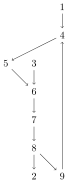

In [15]:
# plot the network graph
using TikzGraphs
using TikzPictures
using Graphs

i = mat2tmpinst("case9")
n = size(i.Y,1)
g = simple_graph(n,is_directed=false)
for line in i.lines
    add_edge!(g,line...)
end
p = TikzGraphs.plot(g)
# save(PDF("../images/case9graph"), p)

In [17]:
g = simple_graph(3,is_directed=false)
add_edge!(g,1,2)

edge [1]: 1 -- 2

In [20]:
Graphs.plot(g,)

Format: "x11" not recognized. Use one of: canon cmap cmapx cmapx_np dot eps fig gv imap imap_np ismap pic plain plain-ext pov ps ps2 svg tk vml xdot xdot1.2 xdot1.4


LoadError: LoadError: write: broken pipe (EPIPE)
while loading In[20], in expression starting on line 1

In [21]:
methods(Graphs.plot)

# 1 method for generic function "plot":
plot(g::Graphs.AbstractGraph{V,E}) at /home/jkersulis/.julia/v0.4/Graphs/src/dot.jl:91

## Checking optimization solutions
The ultimate test of whether the ISF matrix can indeed predict singularities is to look at the objective values and power flows for flagged lines.



In [1]:
include("../src/TemporalInstanton.jl")
using TemporalInstanton
using MatpowerCases

  likely near /home/jkersulis/.julia/v0.4/GraphLayout/src/draw.jl:3
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at ./loading.jl:243
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/jkersulis/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/jkersulis/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading /home/jkersulis/.julia/v0.4/GraphLayout/src/draw.jl, in expression starting on line 3
  likely near /home/jkersulis/.julia/v0.4/GraphLayout/src/draw.jl:23
  likely near /home/jkersulis/.julia/v0.4/GraphLayout/src/draw.jl:135


In [2]:
case = "case118"
maxlines = 1000
println("starting $case")
num_farms = length(unique(loadcase(case,describe=false)["gen"][:,1]))

penetration = 0.5 # penetration of 50 %
d = mat2tmpinst(case)

# Thermal model parameters:
d.Tamb = 35. # C
d.T0 = 60. #46. # initial line steady-state temp

d.time_values = 0:30:300 # five minutes in 30-sec steps
d.int_length = 300. # seconds = 5 min

Gp,Dp,Rp = (d.G0, d.D0, d.R0)
d.G0 = [Gp;Gp;Gp;Gp;Gp;Gp]
d.D0 = [Dp;Dp;Dp;Dp;Dp;Dp]
d.R0 = [Rp;1.1*Rp;1.2*Rp;1.1*Rp;Rp;0.9*Rp]

n = length(d.k)
nr = length(d.Ridx)
T = convert(Int64,length(d.G0)/n)

timed_results = @timed solve_temporal_instanton(d,maxlines);
results = timed_results[1]
o = process_instanton_results(results,n,nr,T,return_as_type=true);

starting case118
r=0 check:		removing 9 lines
ISF pre-check:		flagging [113,177,183,184]


In [3]:
ord = sortperm([s[1] for s in o.score])
o.score[ord]

173-element Array{Tuple{Float64,Int64},1}:
 (0.007213131203667574,42) 
 (0.023149943400986493,116)
 (0.025413622744148844,136)
 (0.03712244171991897,38)  
 (0.04244822809598099,174) 
 (0.055408524738751186,41) 
 (0.07268761708158206,142) 
 (0.12613401609957586,163) 
 (0.1273759785709693,123)  
 (0.14652444837581863,119) 
 (0.21267580322094895,68)  
 (0.2603936637155699,164)  
 (0.39229640276943595,76)  
 ⋮                         
 (754.4350882066941,139)   
 (1227.6688968249541,3)    
 (1252.336720126979,13)    
 (1780.0714744697257,2)    
 (2151.1362169135996,50)   
 (2444.9513523652845,122)  
 (2577.7569062400476,121)  
 (4122.282622104177,180)   
 (18130.629908356164,47)   
 (26004.538845982057,49)   
 (26523.508071373144,182)  
 (279614.4507134098,46)    

Sure enough, there are no secular equation solutions for the lines flagged by the ISF pre-check. In fact, the set of lines for which there are solutions is the set of all lines minus lines that have zero resistance and lines flagged by the pre-check.

Using the non-zero resistance check and ISF pre-check should be sufficient to ensure a reasonable secular equation solution exists for all lines that enter into the analysis itself.

In [4]:
sort(union(find(d.res.== 0),[s[2] for s in o.score],[113,177,183,184])) ==  collect(1:186)

true